In [ ]:
from fastai.vision import *

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls

gdrive	sample_data


In [ ]:
#/content/gdrive/My Drive/test1.zip

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

import io


import zipfile
#https://drive.google.com/open?id=1aVVieDaek7T7ouia1VqVgrbosTP34KGr
file_id="1aVVieDaek7T7ouia1VqVgrbosTP34KGr"
downloaded=drive.CreateFile({'id':file_id})
downloaded.GetContentFile('Dataset.zip')
!unzip Dataset.zip


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate

bs = 64  #batch size: if your GPU is running out of memory, set a smaller batch size, i.e 16
sz = 224 #image size
PATH = '/content/gdrive/My Drive/Dataset'

In [ ]:
classes = []
for d in os.listdir(PATH):
    if os.path.isdir(os.path.join(PATH, d)) and not d.startswith('.'):
        classes.append(d) 
print ("There are ", len(classes), "classes:\n", classes) 

There are  2 classes:
 ['Stress', 'Non-stess']


In [ ]:
for c in classes:
    print ("Class:", c)
    verify_images(os.path.join(PATH, c), delete=True);

Class: Stress


Class: Non-stess


In [ ]:
np.random.seed(43)

In [ ]:
data  = ImageDataBunch.from_folder(PATH, ds_tfms=get_transforms(flip_vert=True, max_rotate=50.0), size=sz, bs=bs, valid_pct=0.2).normalize(imagenet_stats)
print ("There are", len(data.train_ds), "training images and", len(data.valid_ds), "validation images." )


In [ ]:
print ("There are", len(data.train_ds), "training images and", len(data.valid_ds), "validation images." )

There are 2528 training images and 631 validation images.


In [ ]:


tfms=get_transforms()
data = (ImageList.from_folder(PATH)
.split_by_rand_pct(valid_pct=0.2)
.label_from_folder()
.transform(tfms,size=448)
.databunch()).normalize(imagenet_stats)


In [ ]:
from sklearn.model_selection import StratifiedKFold 

In [ ]:
df=data.to_df()
df.head()

,x,y
0,Stress/img_thermal_1575945216841.jpg,Stress
1,Stress/img_thermal_1575945217126.jpg,Stress
2,Stress/img_thermal_1575945217359.jpg,Stress
3,Stress/img_thermal_1575945219294.jpg,Stress
4,Stress/img_thermal_1575945219601.jpg,Stress


In [ ]:
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

In [ ]:
acc_val

[array(0.030769, dtype=float32),
 array(0.015385, dtype=float32),
 array(0.03125, dtype=float32),
 array(0.03125, dtype=float32),
 array(0.015625, dtype=float32)]

In [ ]:

acc_val=[]
for train_index, val_index in skf.split(df.index,df['y']):
  data_fold=(ImageList.from_df(df,PATH)
  .split_by_idxs(train_index,val_index)
  .label_from_df()
  .transform(tfms,size=224)
  .databunch(num_workers=0)).normalize(imagenet_stats)
  learn = cnn_learner(data_fold,models.resnet34,metrics=accuracy)
  learn.fit_one_cycle(4)
  loss,acc=learn.validate()
  acc_val.append(acc.numpy())
  

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,accuracy,time
0,0.703542,0.251598,0.901186,02:39
1,0.481968,0.143338,0.946640,02:35
2,0.361481,0.140053,0.954545,02:33
3,0.294628,0.137085,0.952569,02:33


epoch,train_loss,valid_loss,accuracy,time
0,0.654247,0.372102,0.885375,02:34
1,0.442146,0.195651,0.926877,02:32
2,0.338902,0.176125,0.938735,02:34
3,0.287769,0.165096,0.928854,02:35


epoch,train_loss,valid_loss,accuracy,time
0,0.654212,0.241513,0.924901,02:38
1,0.466617,0.174035,0.948617,02:35
2,0.361138,0.111190,0.954545,02:34
3,0.282523,0.093011,0.970356,02:34


epoch,train_loss,valid_loss,accuracy,time
0,0.583198,0.291925,0.912871,02:35
1,0.421636,0.226662,0.928713,02:35
2,0.338050,0.204134,0.920792,02:35
3,0.272672,0.182289,0.930693,02:35


epoch,train_loss,valid_loss,accuracy,time
0,0.644017,0.286179,0.908911,02:35
1,0.416328,0.197185,0.940594,02:35
2,0.310116,0.147205,0.950495,02:35
3,0.261367,0.144190,0.952475,02:36


In [ ]:
"""

kf = KFold(n_splits=2, random_state=379)
epochs = 6
lr = 1e-2
preds = []
for data.train_ds, data.valid_ds in kf.split(classes):
    data = create_databunch(data.valid_ds)
    learn = create_cnn(data, models.resnet34, metrics=[accuracy])
    learn.fit_one_cycle(epochs, slice(lr))
    learn.unfreeze()
    learn.fit_one_cycle(epochs, slice(lr/400, lr/4))
    learn.fit_one_cycle(epochs, slice(lr/800, lr/8))
    preds.append(learn.get_preds(ds_type=DatasetType.Test))

    """

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

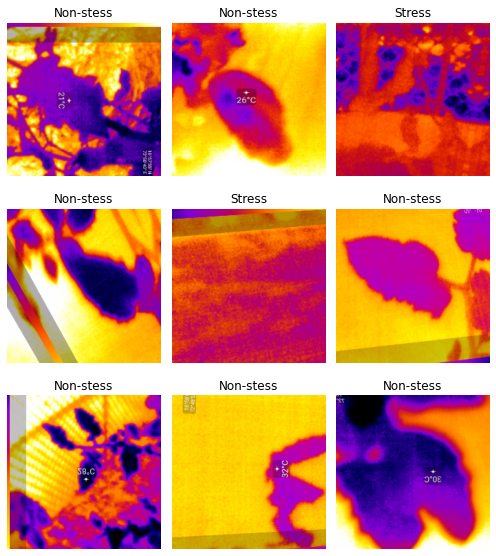

In [ ]:
data.show_batch(rows=3, figsize=(7,8))

In [ ]:
learn = cnn_learner(data, models.vgg19_bn)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


In [ ]:
learn.model

In [ ]:
learn.metrics=[error_rate,
               accuracy,
               Precision(),
               Recall(),
               FBeta(),
               AUROC()]

In [ ]:
learn.fit_one_cycle(1)

In [ ]:

learn.fit_one_cycle(5)


#learn.fit_one_cycle(3,max_lr=1e-5)

In [ ]:
learn.fit_one_cycle(2)

In [ ]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

In [ ]:
learn.save('stage-1')

In [ ]:
learn.export('a.pkl')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [ ]:
img = learn.data.train_ds[1][0]
learn.predict(img)


(Category stress, tensor(1), tensor([0.0513, 0.9487]))

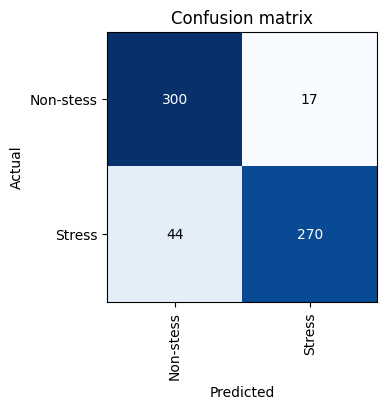

In [20]:
interp.plot_confusion_matrix(figsize=(6,4), dpi=100)

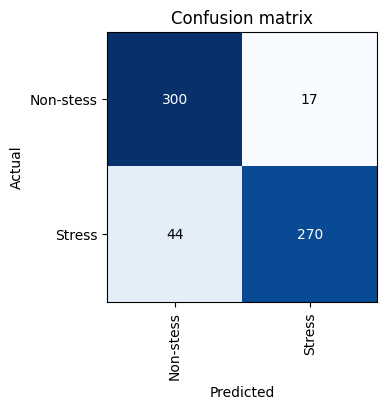

In [ ]:
interp.plot_confusion_matrix(figsize=(6,4), dpi=100)

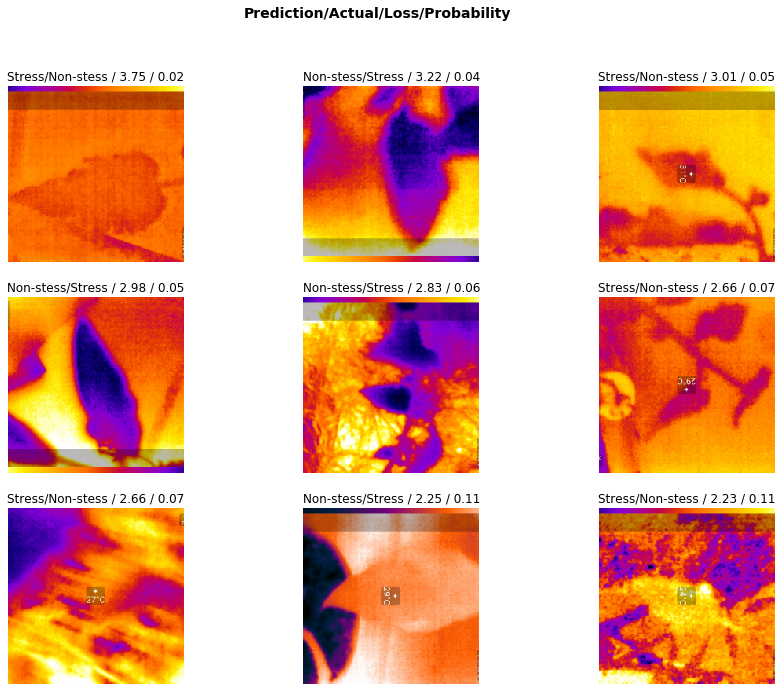

In [ ]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=False)

In [ ]:
#unfreeze model

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(1)

In [ ]:
from fastai import *
from fastai.vision import *

In [ ]:
PATH = '/content/gdrive/My Drive/Dataset'

In [ ]:
classes = [ 'stress','non-stress']


In [ ]:
data2 = ImageDataBunch.single_from_classes(PATH, classes, ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)


In [ ]:
load_learner(PATH)

In [ ]:
learn=create_cnn(data2, models.resnet34, metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [ ]:
learn=load_learner(PATH,'a.pkl')

In [ ]:
str(pred_class)

'non-stress'

In [ ]:
type(pred_class)

fastai.core.Category

In [ ]:
pred_idx

tensor(0)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


It is a Non-stess plant


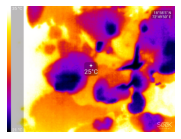

In [ ]:
img = open_image("4.jpg")
pred_class,pred_idx,outputs = learn.predict(img)
img.show()
print ("It is a", pred_class,"plant")

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


It is a Stress plant


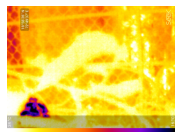

In [ ]:
img = open_image("1.jpg")
pred_class,pred_idx,outputs = learn.predict(img)
img.show()
print ("It is a", pred_class,"plant")

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.recorder.plot_losses()

In [ ]:
acc_val

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
learn.load('stage-1')

In [ ]:
learn=load_learner(PATH,'a.pkl')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute o

In [ ]:
classes = ['stress', 'non-stress']
data2 = ImageDataBunch.single_from_classes(path, classes, ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)
learn = create_cnn(data2, models.resnet34)
#learn.load('stage-1')

NameError: ignored

In [ ]:
path = '/content/drive/My Drive/best' #The path of your test image
ata  = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), size=224, bs=bs, valid_pct=0.2).normalize(imagenet_stats)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


You can deactivate this warning by passing `no_check=True`.


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


It is a stress plant


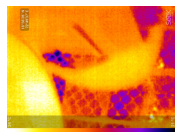

In [ ]:
img = open_image(get_image_files(path)[5])
pred_class,pred_idx,outputs = learn.predict(img)
img.show()
print ("It is a", pred_class,"plant")

In [ ]:
img = open_image(get_image_files(path)[6])
pred_class,pred_idx,outputs = learn.predict(img)
img.show()
print ("It is a", pred_class,"plant")

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


It is a non-stress plant


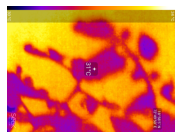

In [ ]:
img = open_image(get_image_files(path)[3])
pred_class,pred_idx,outputs = learn.predict(img)
img.show()
print ("It is a", pred_class,"plant")

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


It is a stress plant


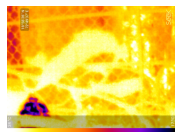

In [ ]:
img = open_image(get_image_files(path)[2])
pred_class,pred_idx,outputs = learn.predict(img)
img.show()
print ("It is a", pred_class,"plant")